### DEBUGing torsion tree issue

#### Step 1 - define all the functions needed

In [1]:

from AutoDockTools.AutoDockBondClassifier import AutoDockBondClassifier
from MolKit.molecule import AtomSet
from MolKit.torTree import TorTree

def get_tor_tree_nodes(ligand_tor_tree):
    N = []
    current_level = [ligand_tor_tree.rootNode]
    while current_level:
        next_level = [c for n in current_level for c in n.children]
        N.extend(next_level)
        current_level = next_level
    return N

def check_tor_tree(node, parent=None):
    if parent and node.bond[1] not in parent.atomList:
        parent.atomList.append(node.bond[1])
    for child in node.children:
        check_tor_tree(child, node)
        
def make_tor_tree(fragment, root_name, ligand=None, previous_fragment=None):
    ## -------------------------------------------------------------
    ## prepare ligand should have implemented this bond assessment
    ## trust prepare ligand and not mess with it?
    ## -------------------------------------------------------------
    '''
    # classify all the fragment's bonds, and initialize their attributes
    classes = AutoDockBondClassifier().classify(fragment.allAtoms.bonds[0])
    fragment.allAtoms.bonds[
        0
    ].possibleTors = False  # bond associated with a possible torsion
    fragment.allAtoms.bonds[
        0
    ].activeTors = False  # bond associated with an active torsion
    fragment.allAtoms.bonds[0].incycle = False  # bond that belongs to a cycle
    fragment.allAtoms.bonds[0].hrotator = False  # bond that rotates only hydrogens
    fragment.allAtoms.bonds[0].amdbond = False  # amide bond

    # set the values of the fragment's bond attributes, based on the classification
    classes["cycle"].incycle = True
    classes["amide"].amdbond = True
    for a in classes["hydrogenRotators"]:  # this class contains atoms, not bonds
        a.bonds.get(lambda b: b.neighborAtom(a).element != "H").hrotator = True
    torsions = classes["rotatable"].get(
        lambda b: not (b.incycle or b.amdbond or b.hrotator)
    )

    # if the ligand has been provided, use it to check the fragment's torsions
    # (in some cases, the fragment might have torsions that are not in the ligand)
    if ligand:
        ligand_torsions = [b for b in ligand.allAtoms.bonds[0] if b.possibleTors]
        for tor in torsions:
            tor_atoms = set([tor.atom1.name, tor.atom2.name])
            if not [
                b
                for b in ligand_torsions
                if set([b.atom1.name, b.atom2.name]) == tor_atoms
            ]:
                torsions.remove(tor)

    # if the previous fragment has been provided,
    # check that all its possible torsions are in the current fragment's torsion tree
    if previous_fragment:
        for tor in [b for b in previous_fragment.allAtoms.bonds[0] if b.possibleTors]:
            bond = next(
                b
                for b in fragment.allAtoms.bonds[0]
                if set([b.atom1.name, b.atom2.name])
                == set([tor.atom1.name, tor.atom2.name])
            )
            if bond not in torsions:
                torsions.append(bond)

    # create the fragment's torsion tree
    torsions.possibleTors = True
    torsions.activeTors = True
    fragment.TORSDOF = len(torsions)  # number of possible torsions
    fragment.torscount = len(torsions)  # number of active torsions
    fragment.ROOT = next(a for a in fragment.allAtoms if a.name == root_name)
    fragment.ROOT.rnum0 = 0
    '''
    ## -------------------------------------------------------------
    ## IMPORTANT - TorTree constructor is a bit weird; 
    ## be caredul about parser/root inputs!
    # print(fragment.parser.allLines)
    fragment.parser.allLines = fragment.pdbqt_str.split("\n")
    #print(fragment.parser.allLines)
    fragment.torTree = TorTree(fragment.parser, fragment.ROOT)
    ## try out the other constructor?
    ## no, the other constructor has some issue 
    ## where it does not connect nodes as children
    #fragment.torTree = TorTree(parser = None, rootAtom = fragment.ROOT)

    # check that the torsion tree has been properly built
    check_tor_tree(fragment.torTree.rootNode)

    # sort the fragment's atoms based on their index in the torsion tree
    # (this is needed because of how StateToCoords works; see mglutil.math.statetocoords)
    fragment.allAtoms = AtomSet(
        sorted(
            fragment.allAtoms, key=lambda a: a.tt_ind if hasattr(a, "tt_ind") else False
        )
    )

#### Step 2 - Load ligands

In [8]:
from dinc_ensemble import *
from dinc_ensemble.ligand.core.convert_molecule import *

#### 0 DoF example

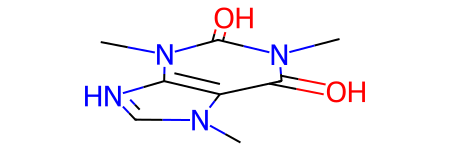

In [3]:
# zero DoF example
ligand_dinc_mol = load_ligand("../data/caffeine.mol2")
rdkit_mol = ligand_dinc_mol._rdkit_molecule
rdkit_mol

In [4]:
ligand_dinc_mol.bonds

,atom1_molkit_full_name,atom2_molkit_full_name,origin,bond_order,incycle_,hrotator_,amdbond_,possibleTors_,activeTors_,idx_atom1,idx_atom2
0,caffeine:default:CFF1:N1.0,caffeine:default:CFF1:C2.1,File,1,True,False,False,False,False,0,1
1,caffeine:default:CFF1:N1.0,caffeine:default:CFF1:C10.2,File,1,False,False,False,False,False,0,2
2,caffeine:default:CFF1:N1.0,caffeine:default:CFF1:C6.3,File,1,True,False,False,False,False,0,3
3,caffeine:default:CFF1:C2.1,caffeine:default:CFF1:N3.4,File,1,True,False,False,False,False,1,4
4,caffeine:default:CFF1:C2.1,caffeine:default:CFF1:O11.5,File,2,False,False,False,False,False,1,5
5,caffeine:default:CFF1:C6.3,caffeine:default:CFF1:C5.8,File,1,True,False,False,False,False,3,8
6,caffeine:default:CFF1:C6.3,caffeine:default:CFF1:O13.10,File,2,False,False,False,False,False,3,10
7,caffeine:default:CFF1:N3.4,caffeine:default:CFF1:C12.6,File,1,False,False,False,False,False,4,6
8,caffeine:default:CFF1:N3.4,caffeine:default:CFF1:C4.7,File,1,True,False,False,False,False,4,7
9,caffeine:default:CFF1:C4.7,caffeine:default:CFF1:C5.8,File,2,True,False,False,False,False,7,8


0


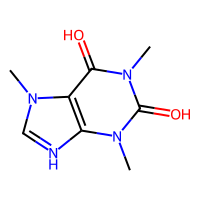

In [5]:
from rdkit.Chem import rdMolDescriptors

n_rot = rdMolDescriptors.CalcNumRotatableBonds(rdkit_mol)
print(n_rot)
# no possible torsions because the hydrogen rotators are considered rigid for the docking purposes
draw_bond_property_rdkit(ligand_dinc_mol, 
                         ligand_dinc_mol.bonds.possibleTors_==True)

In [6]:
from copy import deepcopy

'''
# meeko style
# meeko torsion tree
print(ligand_dinc_mol.molkit_molecule.torTree.printTree())
# meeko torsion tree
test_mol = deepcopy(ligand_dinc_mol.molkit_molecule)
root_atom =  test_mol.allAtoms[0]
print(root_atom.name)
print(root_atom._uniqIndex)
make_tor_tree(test_mol, root_atom.name)
print(test_mol.torTree.printTree())
'''

make_tor_tree(ligand_dinc_mol.molkit_molecule, root_name="N1")
ligand_dinc_mol.molkit_molecule.torTree.printTree()

['REMARK  0 active torsions:', "REMARK  status: ('A' for Active; 'I' for Inactive)", 'ROOT', 'ATOM      1  N1  CFF d   1      38.696 -58.440 101.938  0.00  0.00    -0.269 N ', 'ATOM      2  C2  CFF d   1      37.425 -58.134 102.720  0.00  0.00     0.332 A ', 'ATOM      3  C10 CFF d   1      39.942 -58.114 102.677  0.00  0.00     0.164 C ', 'ATOM      4  C6  CFF d   1      38.741 -58.984 100.637  0.00  0.00     0.282 A ', 'ATOM      5  N3  CFF d   1      36.324 -58.434 102.049  0.00  0.00    -0.286 N ', 'ATOM      6  O11 CFF d   1      37.551 -57.677 103.803  0.00  0.00    -0.246 OA', 'ATOM      7  C12 CFF d   1      34.997 -58.178 102.715  0.00  0.00     0.163 C ', 'ATOM      8  C4  CFF d   1      36.310 -58.987 100.736  0.00  0.00     0.167 A ', 'ATOM      9  C5  CFF d   1      37.463 -59.260 100.045  0.00  0.00     0.151 A ', 'ATOM     10  N9  CFF d   1      35.249 -59.296 100.049  0.00  0.00    -0.223 NA', 'ATOM     11  O13 CFF d   1      39.875 -59.206 100.065  0.00  0.00    -0.265

#### 0 DoF multiple ligands

In [2]:
from glob import glob
from dinc_ensemble import *
from dinc_ensemble.ligand.core.convert_molecule import *
from rdkit.Chem import rdMolDescriptors

In [3]:
mol2_files = glob("../data/pdbbind_test_ligands/*dof_0.mol2")
mol2_files

['../data/pdbbind_test_ligands/5a4l_ligand_dof_0.mol2',
 '../data/pdbbind_test_ligands/3s1g_ligand_dof_0.mol2',
 '../data/pdbbind_test_ligands/1l5q_ligand_dof_0.mol2']

/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom1_name"] = selected_bonds["atom1_molkit_full_name"].apply(lambda x: x.split(":")[-1].split(".")[0])
/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom2_name"] = selected_bonds["atom2_molkit_full_name"].apply(lambda x: x.spli

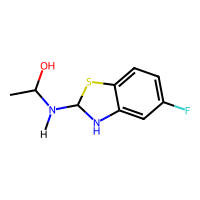

TEST-0
TEST-0-1
TEST-buildtree-root
TEST-buildtree-node-0
TEST-adj-ats
1
TEST-adj-ats expanded
15
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAG == 5a4l_ligand_dof_0:default:ZC31:CAL
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:SAI == 5a4l_ligand_dof_0:default:ZC31:CAL
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:CAL == 5a4l_ligand_dof_0:default:ZC31:NAH
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAG == 5a4l_ligand_dof_0:default:ZC31:CAM
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAG == 5a4l_ligand_dof_0:default:ZC31:CAL
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:CAN == 5a4l_ligand_dof_0:default:ZC31:SAI
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:SAI == 5a4l_ligand_dof_0:default:ZC31:CAL
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:CAL == 5a4l_ligand_dof_0:default:ZC31:NAH
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAH == 5a4l_ligand_dof_0:default:ZC31:CAJ
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAH == 5a4l_ligand_dof_0:default:ZC31:H4
0
TEST-bond
5a4l_ligand_dof_0:default:ZC31:NAG == 5a4l_

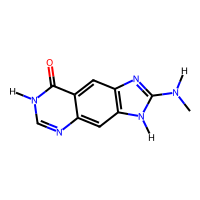

TEST-0
TEST-0-1
TEST-buildtree-root
TEST-buildtree-node-0
TEST-adj-ats
1
TEST-adj-ats expanded
19
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C5 == 3s1g_ligand_dof_0:default:ITE1:N3
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C5 == 3s1g_ligand_dof_0:default:ITE1:N2
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:N4 == 3s1g_ligand_dof_0:default:ITE1:C5
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C5 == 3s1g_ligand_dof_0:default:ITE1:N3
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:N3 == 3s1g_ligand_dof_0:default:ITE1:C6
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:N3 == 3s1g_ligand_dof_0:default:ITE1:H
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C4 == 3s1g_ligand_dof_0:default:ITE1:N2
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C5 == 3s1g_ligand_dof_0:default:ITE1:N2
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:N4 == 3s1g_ligand_dof_0:default:ITE1:C5
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:C7 == 3s1g_ligand_dof_0:default:ITE1:N4
0
TEST-bond
3s1g_ligand_dof_0:default:ITE1:N4 == 3s1g_ligand_dof_0:default:

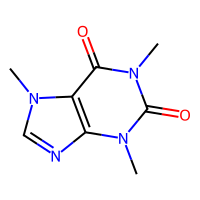

TEST-0
TEST-0-1
TEST-buildtree-root
TEST-buildtree-node-0
TEST-adj-ats
1
TEST-adj-ats expanded
14
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C2
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C10
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C6
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C2
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:C2 == 1l5q_ligand_dof_0:default:CFF1:N3
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:C2 == 1l5q_ligand_dof_0:default:CFF1:O11
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C10
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:N1 == 1l5q_ligand_dof_0:default:CFF1:C6
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:C6 == 1l5q_ligand_dof_0:default:CFF1:C5
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:C6 == 1l5q_ligand_dof_0:default:CFF1:O13
0
TEST-bond
1l5q_ligand_dof_0:default:CFF1:C2 == 1l5q_ligand_dof_0:def

In [4]:
for mol2_file in mol2_files: 
    #print(mol2_file)
    ligand_dinc_mol = load_ligand(mol2_file)
    rdkit_mol = to_rdkit(ligand_dinc_mol, flatten=True, removeH=True)
    n_rot = rdMolDescriptors.CalcNumRotatableBonds(rdkit_mol)
    #print(n_rot)
    # no possible torsions because the hydrogen rotators are considered rigid for the docking purposes
    svg_mol = draw_bond_property_rdkit(ligand_dinc_mol, 
                            ligand_dinc_mol.bonds.possibleTors_==True)
    display(svg_mol)
    atom_molkit_full_name = ligand_dinc_mol.atoms.reset_index().molkit_full_name[0]
    #print(atom_molkit_full_name)
    root_atom = atom_molkit_full_name.split(":")[-1].split(".")[0]
    #print(root_atom)
    make_tor_tree(ligand_dinc_mol.molkit_molecule, root_name=root_atom)
    ligand_dinc_mol.molkit_molecule.torTree.printTree()

### N DoF example - 5d7x

../data/pdbbind_test_ligands/1klu_ligand_dof_50.mol2
adding gasteiger charges to peptide
56


/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom1_name"] = selected_bonds["atom1_molkit_full_name"].apply(lambda x: x.split(":")[-1].split(".")[0])
/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom2_name"] = selected_bonds["atom2_molkit_full_name"].apply(lambda x: x.spli

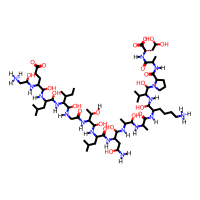

1klu_ligand_dof_50:default:GLY1:N1.0
REMARK WARNING: 32 MAX_TORS EXCEEDED!!!
REMARK  50 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: N1_1  and  CA2_2 
REMARK    2  A    between atoms: CA2_2  and  C3_3 
REMARK       I    between atoms: C3_3  and  N1_5 
REMARK    3  A    between atoms: N1_5  and  CA2_6 
REMARK    4  A    between atoms: CA2_6  and  C3_7 
REMARK    5  A    between atoms: CA2_6  and  CB5_9 
REMARK       I    between atoms: C3_7  and  N1_14 
REMARK    6  A    between atoms: CB5_9  and  CG6_10 
REMARK    7  A    between atoms: CG6_10  and  CD7_11 
REMARK    8  A    between atoms: N1_14  and  CA2_15 
REMARK    9  A    between atoms: CA2_15  and  C3_16 
REMARK   10  A    between atoms: CA2_15  and  CB5_18 
REMARK       I    between atoms: C3_16  and  N1_22 
REMARK   11  A    between atoms: CB5_18  and  CG6_19 
REMARK   12  A    between atoms: N1_22  and  CA2_23 
REMARK   13  A    between atoms: CA2_23  and  C3_24 
REMARK  

/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom1_name"] = selected_bonds["atom1_molkit_full_name"].apply(lambda x: x.split(":")[-1].split(".")[0])
/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom2_name"] = selected_bonds["atom2_molkit_full_name"].apply(lambda x: x.spli

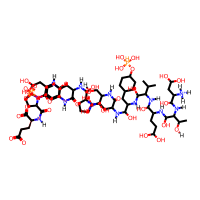

2lct_ligand_dof_50:default:ASP1:N1.0
REMARK WARNING: 32 MAX_TORS EXCEEDED!!!
REMARK  50 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: N1_1  and  CA2_2 
REMARK    2  A    between atoms: CA2_2  and  C3_3 
REMARK    3  A    between atoms: CA2_2  and  CB5_5 
REMARK       I    between atoms: C3_3  and  N1_9 
REMARK    4  A    between atoms: CB5_5  and  CG6_6 
REMARK    5  A    between atoms: N1_9  and  CA2_10 
REMARK    6  A    between atoms: CA2_10  and  C3_11 
REMARK    7  A    between atoms: CA2_10  and  CB5_13 
REMARK       I    between atoms: C3_11  and  N1_16 
REMARK    8  A    between atoms: CB5_13  and  OG1_14 
REMARK    9  A    between atoms: N1_16  and  CA2_17 
REMARK   10  A    between atoms: CA2_17  and  C3_18 
REMARK   11  A    between atoms: CA2_17  and  CB5_20 
REMARK       I    between atoms: C3_18  and  N1_25 
REMARK   12  A    between atoms: CB5_20  and  CG6_21 
REMARK   13  A    between atoms: CG6_21  and  CD7_22 
REM

/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom1_name"] = selected_bonds["atom1_molkit_full_name"].apply(lambda x: x.split(":")[-1].split(".")[0])
/home/anja/Documents/dinc-ensemble/dinc-ensemble-bin/dinc_ensemble/ligand/core/convert_molecule.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_bonds["atom2_name"] = selected_bonds["atom2_molkit_full_name"].apply(lambda x: x.spli

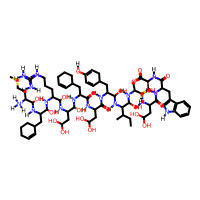

6gbe_ligand_dof_50:default:MET1:N1.0
REMARK WARNING: 32 MAX_TORS EXCEEDED!!!
REMARK  50 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: N1_1  and  CA2_2 
REMARK    2  A    between atoms: CA2_2  and  C3_3 
REMARK    3  A    between atoms: CA2_2  and  CB5_5 
REMARK       I    between atoms: C3_3  and  N1_9 
REMARK    4  A    between atoms: CB5_5  and  CG6_6 
REMARK    5  A    between atoms: CG6_6  and  SD_7 
REMARK    6  A    between atoms: N1_9  and  CA2_10 
REMARK    7  A    between atoms: CA2_10  and  C3_11 
REMARK    8  A    between atoms: CA2_10  and  CB5_13 
REMARK       I    between atoms: C3_11  and  N1_20 
REMARK    9  A    between atoms: CB5_13  and  CG6_14 
REMARK   10  A    between atoms: N1_20  and  CA2_21 
REMARK   11  A    between atoms: CA2_21  and  C3_22 
REMARK   12  A    between atoms: CA2_21  and  CB5_24 
REMARK       I    between atoms: C3_22  and  N1_31 
REMARK   13  A    between atoms: CB5_24  and  CG6_25 
REMARK

In [5]:
from glob import glob
from dinc_ensemble import *
from dinc_ensemble.ligand.core.convert_molecule import *
from rdkit.Chem import rdMolDescriptors
N=50
mol2_files_1dof = glob("../data/pdbbind_test_ligands/*dof_{}.mol2".format(N))
for mol2_file in mol2_files_1dof: 
    print(mol2_file)
    ligand_dinc_mol = load_ligand(mol2_file)
    rdkit_mol = to_rdkit(ligand_dinc_mol, flatten=True, removeH=True)
    #display(rdkit_mol)
    n_rot = rdMolDescriptors.CalcNumRotatableBonds(rdkit_mol)
    print(n_rot)
    # no possible torsions because the hydrogen rotators are considered rigid for the docking purposes
    svg_mol = draw_bond_property_rdkit(ligand_dinc_mol, 
                            ligand_dinc_mol.bonds.possibleTors_==True)
    display(svg_mol)
    atom_molkit_full_name = ligand_dinc_mol.atoms.reset_index().molkit_full_name[0]
    print(atom_molkit_full_name)
    print(ligand_dinc_mol.molkit_molecule.pdbqt_str)
    root_atom = atom_molkit_full_name.split(":")[-1].split(".")[0]
    print(root_atom)
    make_tor_tree(ligand_dinc_mol.molkit_molecule, root_name=root_atom)
    ligand_dinc_mol.molkit_molecule.torTree.printTree()